In [1]:
import pathlib
import os
import statistics
from multiprocessing import Pool, Manager

from symusic import Score
import pandas as pd
from tqdm import tqdm

In [2]:
def polyphony_rate(notes, threshold=2):
    # https://hermandong.com/muspy/doc/metrics.html#muspy.metrics.polyphony_rate
    try:
        events = []
        for note in notes:
            events.append((note.start, 1))
            events.append((note.end, -1))
    
        events.sort()
        active_notes = 0
        polyphonic_steps = 0
        total_steps = 0
        last_time = None
    
        for time, change in events:
            if last_time is not None and time != last_time:
                if active_notes > threshold:
                    polyphonic_steps += (time - last_time)
                total_steps += (time - last_time)
            active_notes += change
            last_time = time

        return polyphonic_steps / total_steps
    except:
        return None

In [3]:
def extract_features(midi_path):
    midi_id = midi_path.parts[-2] + '/' + midi_path.stem
    score = Score(midi_path).to('Quarter')

    try:
        global_tempo = round(statistics.median([t.qpm for t in score.tempos]))
    except:
        global_tempo = None
    try:
        time_sig = statistics.mode([(ts.numerator, ts.denominator) for ts in score.time_signatures])
    except:
        time_sig = None

    track_features = []
    for i, t in enumerate(score.tracks):
        track_features.append({
            "midi_id": midi_id,
            "track_id": i,
            "program": 128 if t.is_drum else t.program,
            "num_notes": len(t.notes),
            "end_time": t.end(),
            "polyphony_rate": polyphony_rate(t.notes),
        })

    return {
        "score": {
            "midi_id": midi_id,
            "global_tempo": global_tempo,
            "time_signature": time_sig,
        },
        "tracks": track_features
    }

In [4]:
manager = Manager()
score_data = manager.list()
track_data = manager.list()

midi_files = list(pathlib.Path('data').glob('*/*.mid'))

with Pool(4) as pool:
    for result in tqdm(pool.imap_unordered(extract_features, midi_files), total=len(midi_files)):
        score_data.append(result["score"])
        track_data.extend(result["tracks"])

score_df = pd.DataFrame(list(score_data))
track_df = pd.DataFrame(list(track_data))

score_df.to_csv("score_features.csv", index=False)
track_df.to_csv("track_features.csv", index=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 384696/384696 [10:11<00:00, 628.94it/s]


In [5]:
from matplotlib import pyplot as plt

In [6]:
score_features_csv = "score_features.csv"
score_df = pd.read_csv(score_features_csv)

def plot_histogram(data, column, bins=20, title="", xlabel="", ylabel="Frequency", is_categorical=False):
    plt.figure(figsize=(12, 9))
    if is_categorical:
        # 分类数据绘制柱状图
        value_counts = data[column].value_counts()
        plt.bar(value_counts.index.astype(str), value_counts.values, color='skyblue', edgecolor='black', alpha=0.7)
    else:
        # 连续数据绘制直方图
        plt.hist(data[column], bins=bins, color='skyblue', edgecolor='black', alpha=0.7)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

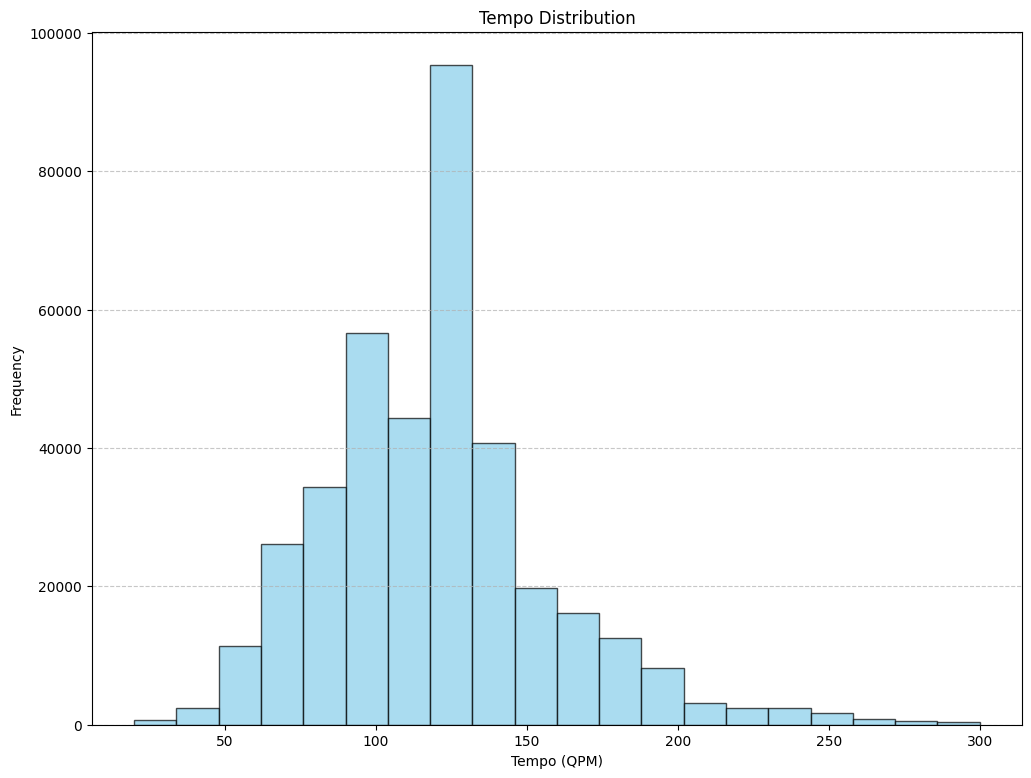

In [7]:
filtered_score_df = score_df[(score_df['global_tempo'] >= 20) & (score_df['global_tempo'] <= 300)]

plot_histogram(filtered_score_df, 'global_tempo', bins=20, 
               title="Tempo Distribution", xlabel="Tempo (QPM)")

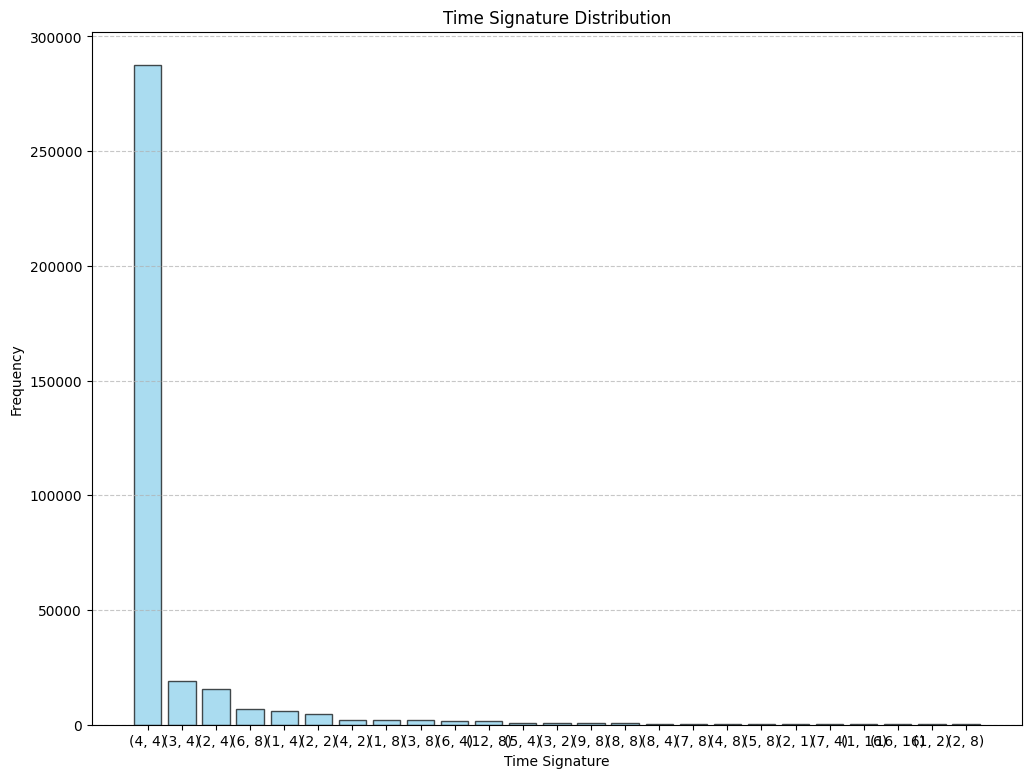

In [8]:
time_signature_counts = score_df['time_signature'].value_counts()

valid_time_signatures = time_signature_counts[time_signature_counts >= 128].index

filtered_score_df = score_df[score_df['time_signature'].isin(valid_time_signatures)]

plot_histogram(filtered_score_df, 'time_signature', 
               title="Time Signature Distribution", xlabel="Time Signature", is_categorical=True)

In [9]:
track_features_csv = "track_features.csv"
track_df = pd.read_csv(track_features_csv)

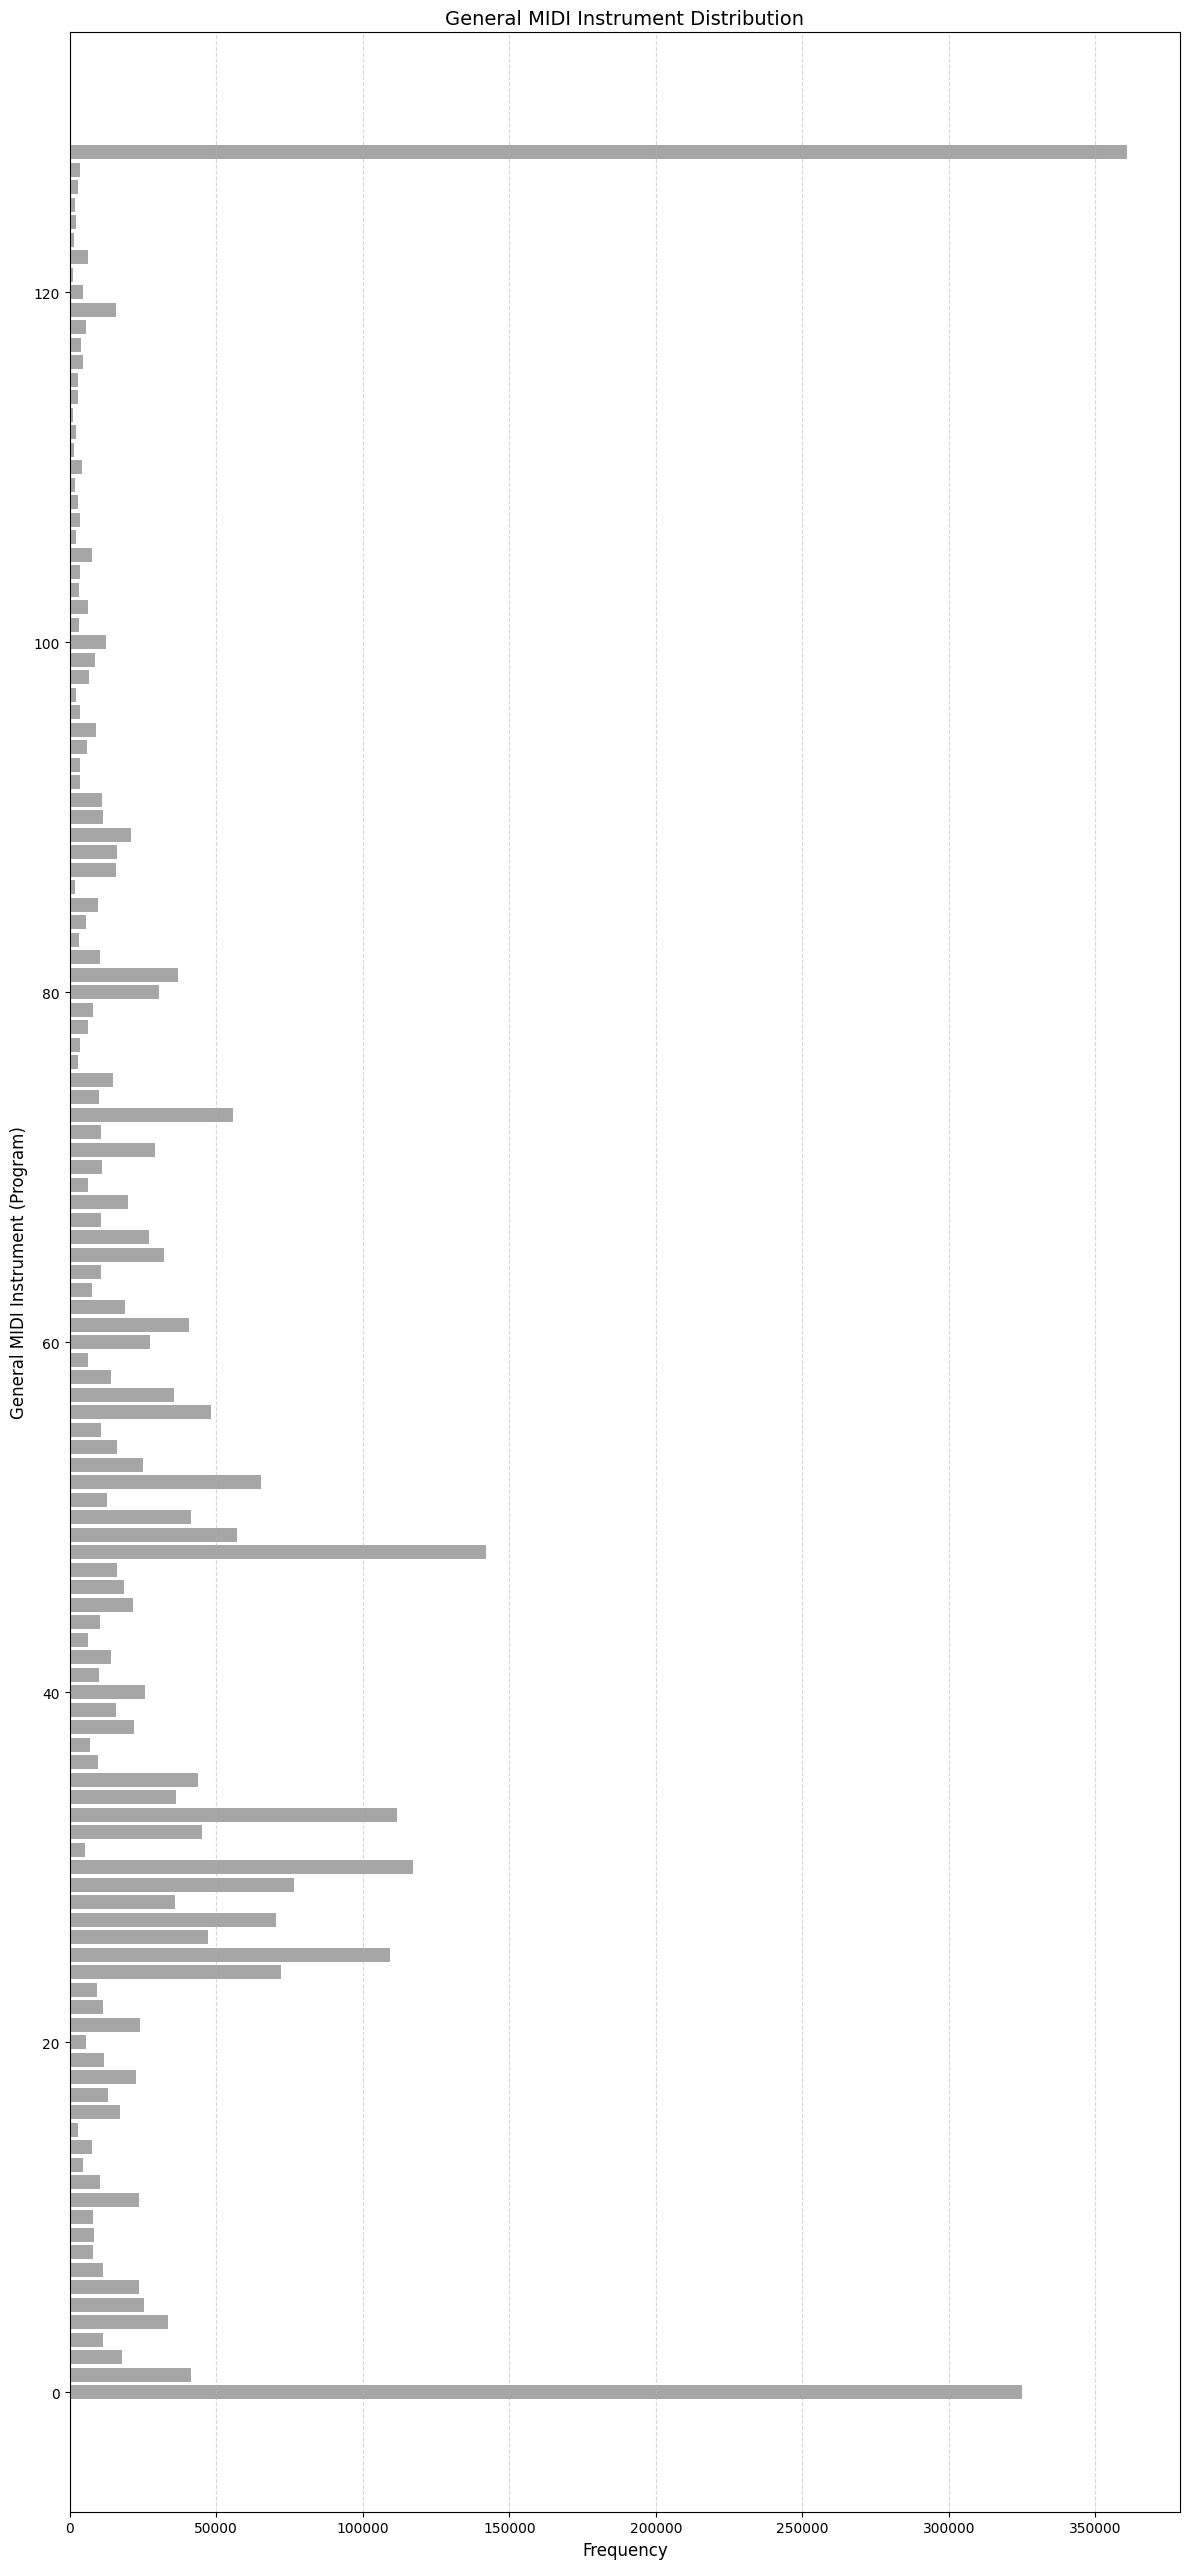

In [10]:
program_counts = track_df['program'].value_counts()

program_counts = program_counts.sort_index()

plt.figure(figsize=(12, len(program_counts) * 0.2))
plt.barh(program_counts.index, program_counts.values, color="gray", alpha=0.7)

plt.title("General MIDI Instrument Distribution", fontsize=14)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("General MIDI Instrument (Program)", fontsize=12)

plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()

plt.show()

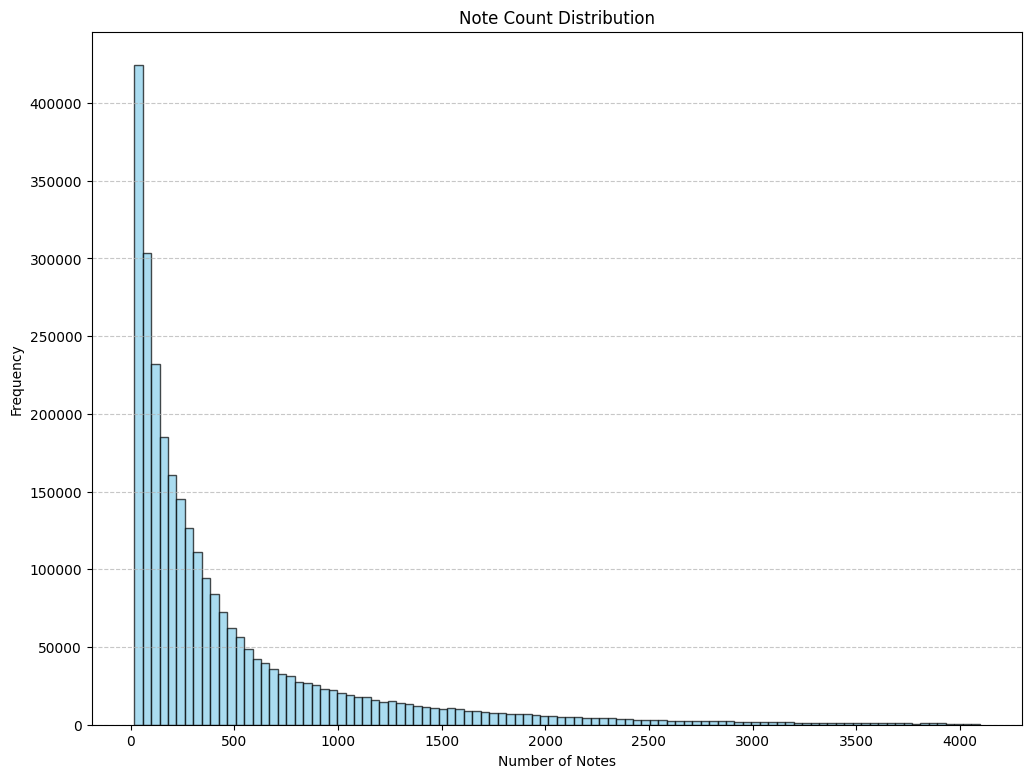

In [11]:
filtered_track_df = track_df[(track_df['num_notes'] >= 16) & (track_df['num_notes'] <= 4096)]

plot_histogram(filtered_track_df, 'num_notes', bins=100, 
               title="Note Count Distribution", xlabel="Number of Notes")

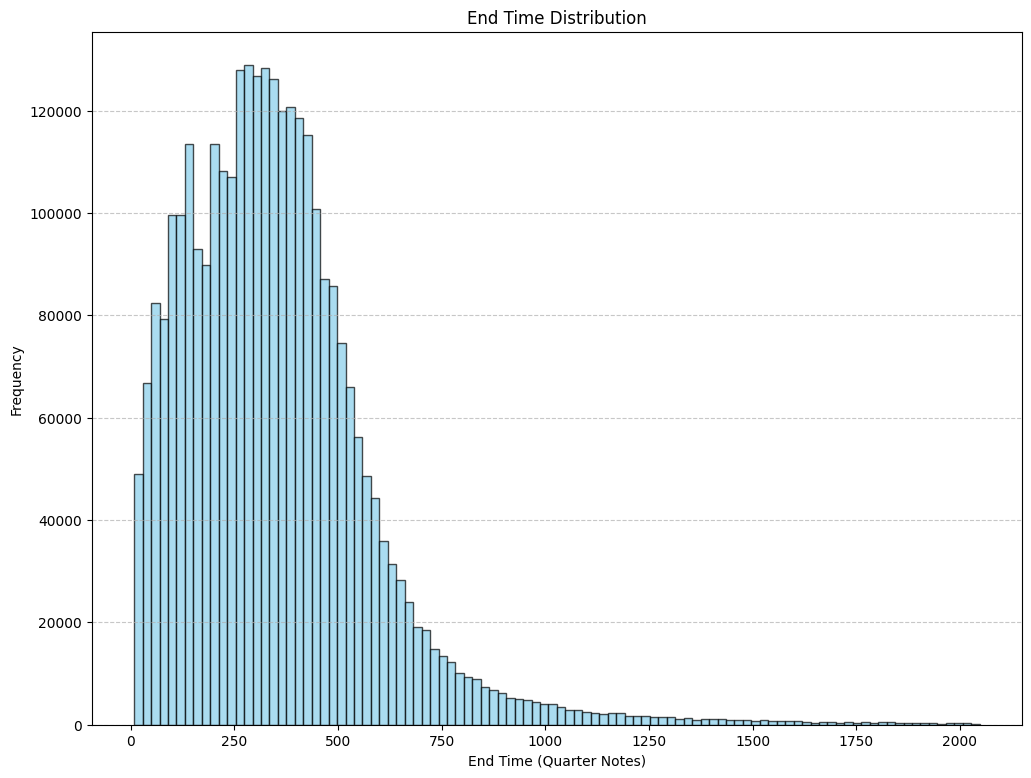

In [12]:
filtered_track_df = track_df[(track_df['end_time'] >= 8) & (track_df['end_time'] <= 2048)]

plot_histogram(filtered_track_df, 'end_time', bins=100, 
               title="End Time Distribution", xlabel="End Time (Quarter Notes)")

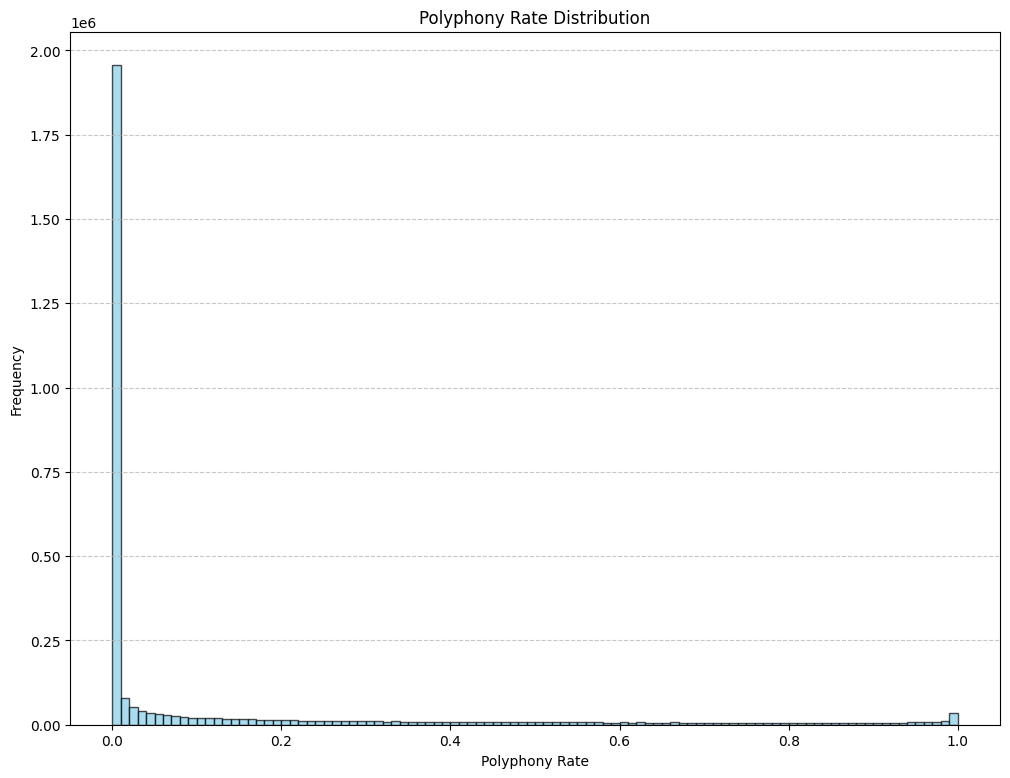

In [13]:
plot_histogram(track_df, 'polyphony_rate', bins=100, 
               title="Polyphony Rate Distribution", xlabel="Polyphony Rate")